In [1]:
import numpy as np
from tensorflow import keras
import time
import glob
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
#import matplotlib as mpl
#import matplotlib.pyplot as plt
import gc
from sklearn.decomposition import PCA
from matplotlib import pyplot
import tensorflow as tf

from PIL import Image
from joblib import dump, load
import zipfile

# load and transform data with pretrained model RESNET50

Provide the path to the local directories with samples for training and testing.

Note: since it's anomaly detection case, training only uses the "good" samples

In [2]:
train_normal_dir = r'C:\Users\...\AnomalyDetection\data\walnuts\train\good'
test_normal_dir = r'C:\Users\...\AnomalyDetection\data\walnuts\test\good'
test_anomaly_dir = r'C:\Users\...\AnomalyDetection\data\walnuts\test\bad'

Load one image from samples to see the image dimensions.

Note: here we assume that all images have same dimensions

In [3]:
example_name = glob.glob(train_normal_dir+'\*.png')[0]
example = np.array(Image.open(example_name))
example_shape = example.shape

Load the pretrained Keras model RESNET50 and set it to fit our sample image.

We add global pulling2D layer instead of original top layer to get a 1D array of features instead of original predictions

In [4]:
pretrained_model = keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=example_shape  )
model = keras.models.Sequential([pretrained_model, keras.layers.GlobalAveragePooling2D()])

Use the model to transform each images into rows of feature values

In [5]:
%%time
data = []

for filename in glob.glob(train_normal_dir+'\*.png'): 
    image = np.array(Image.open(filename))
    features = model.predict(image.reshape((1,example_shape[0],example_shape[1],example_shape[2]))) #pillow doesn't need *255
    data.append(features)
X_train =np.array(data)
X_shape = X_train.shape
X_train = X_train.reshape((X_shape[0],X_shape[2]))

1/1 [==============================] - 1s 1s/step
CPU times: total: 12min 40s
Wall time: 2min 19s


In [6]:
%%time
data = []
labels = []
for filename in glob.glob(test_normal_dir+'\*.png'): 
    image = np.array(Image.open(filename))
    features = model.predict(image.reshape((1,example_shape[0],example_shape[1],example_shape[2]))) #pillow doesn't need *255
    data.append(features)
    labels.append(0)
for filename in glob.glob(test_anomaly_dir+'\*.png'): 
    image = np.array(Image.open(filename))
    features = model.predict(image.reshape((1,example_shape[0],example_shape[1],example_shape[2]))) #pillow doesn't need *255
    data.append(features)
    labels.append(1)
X_labeled = np.array(data)
X_shape = X_labeled.shape
X_labeled = X_labeled.reshape((X_shape[0],X_shape[2]))

1/1 [==============================] - 1s 1s/step
CPU times: total: 19min 56s
Wall time: 3min 33s


# train model

Train PCA model from Scikit-Learn library to fit the training samples

In [7]:
n_components = len(X_train) - 10
pca = PCA(n_components = n_components) 
pca.fit(X_train)

PCA(n_components=79)

# evaluate model

score the samples in test set and plot ROC curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8795045045045046

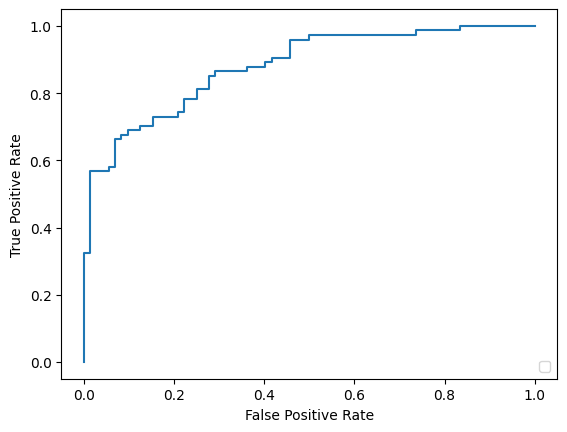

In [8]:
y_pred = -pca.score_samples(X_labeled)
fpr, tpr, thresholds = metrics.roc_curve(labels, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_auc_score(np.array(labels) == 1, y_pred)

check how well the scores we got allow to separate the positive samples from the negative ones

In [9]:
pos_scores = y_pred[np.array(labels) == 1.0]
neg_scores = y_pred[np.array(labels) == 0.0]

In [10]:
z = 2.58          #99%  CI
pos_mean = np.mean(pos_scores)
neg_mean = np.mean(neg_scores)
delta_pos = z*np.std(pos_scores)/len(pos_scores)**(1/2)
delta_neg = z*np.std(neg_scores)/len(neg_scores)**(1/2)

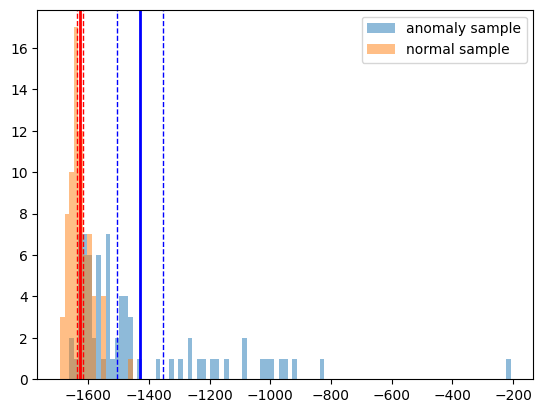

In [11]:
bins = np.linspace(min(y_pred), max(y_pred),100)

pyplot.hist(pos_scores, bins, alpha=0.5, label='anomaly sample')
pyplot.hist(neg_scores, bins, alpha=0.5, label='normal sample')
pyplot.legend(loc='upper right')

pyplot.axvline(x=pos_mean,color='b', linestyle='-',linewidth = 2)
pyplot.axvline(x=pos_mean+delta_pos, color='b', linestyle='--',linewidth = 1)
pyplot.axvline(x=pos_mean-delta_pos, color='b', linestyle='--',linewidth = 1)

pyplot.axvline(x=neg_mean,color='r', linestyle='-',linewidth = 2)
pyplot.axvline(x=neg_mean+delta_neg, color='r', linestyle='--',linewidth = 1)
pyplot.axvline(x=neg_mean-delta_neg, color='r', linestyle='--',linewidth = 1)

Since our use case value TPR more, check what FPR can we get for given values of TPR

Function details:

INPUT: list of labels, list of scores, expected TPR. 

Finds the threshold that matches given TPR 

RETURN: corresponding FPR

In [12]:
def fpr_from_tpr(labels,y_pred,tpr):
    labels = np.array(labels)
    n_neg, n_pos = np.unique(labels,return_counts = True)[1] #"positive" are anomalies, labeled by "1", "negative" - by "o"
    ordered_positive_predictions = np.sort(y_pred[labels == 1])
    pos_index_cutoff = int(np.ceil(tpr * n_pos))
    cutoff = ordered_positive_predictions[n_pos - pos_index_cutoff]
    y_neg = y_pred[labels == 0]
    fpr = len(y_neg[y_neg > cutoff])/n_neg
    return fpr

In [18]:
print(fpr_from_tpr(labels,y_pred,1))
print(fpr_from_tpr(labels,y_pred,0.95))


0.8333333333333334
0.4583333333333333


# save the model

save the Keras CNN model

Note: this model is too big to pickle it, we have to use keras built in methods to save it

In [19]:
saved_model_path = "models/resnet.h5"
model.compile()  #we compile the model to save TF from processing all warnings on SAVE and LOAD
model.save(saved_model_path)


c:\Users\Ivan\work\AnomalyDetection\predictor_app_git\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


save the sklearn PCA model

In [20]:
dump(pca, './models/pca.joblib') 

['./models/pca.joblib']

Save the threshold value for the tpr we chose

In [21]:
def threshold_from_tpr(labels,y_pred,tpr):
    labels = np.array(labels)
    n_neg, n_pos = np.unique(labels,return_counts = True)[1] #"positive" are anomalies, labeled by "1", "negative" - by "1"
    ordered_positive_predictions = np.sort(y_pred[labels == 1])
    pos_index_cutoff = int(np.ceil(tpr * n_pos))
    cutoff = ordered_positive_predictions[n_pos - pos_index_cutoff]
    return cutoff

In [22]:
tpr = 1
threshold = threshold_from_tpr(labels,y_pred,1.0)
dump(threshold,'./models/variables.joblib')

['./models/variables.joblib']

In [4]:
list_files = ['./models/resnet.h5', './models/pca.joblib', './models/variables.joblib']
with zipfile.ZipFile('models/models.zip', 'w') as zipF:
  for file in list_files:
    zipF.write(file, compress_type=zipfile.ZIP_DEFLATED)